In [30]:
"""
preprocessing images or augmenting to enhance training data

steps to achive:
normal distribution of samples with steering angles evenly distributed

resize images
shear
shift
rotate
brightness
shadow patch - draw random polygon
mirror image


"""
import os
import csv
# %matplotlib inline
import cv2
import math

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


def plot_img(image):
    plt.figure()
    plt.imshow(image, cmap="gray")


def _img_specs(image, fake=False):
    if fake:
        return (image['h'], image['w'])
    return image.shape[:2]


def crop_img(image, steer, y_st=66, y_end=135, x_st=0, x_end=None, fake=False):
    if fake:
        image["h"] = y_end - y_st
        image["w"] = x_end if x_end else image["w"] - x_st
        return (image, steer)
    if x_end is None:
        x_end = image.shape[1]
    return (image[y_st:y_end, x_st:x_end], steer)



def resize(image, steer, fake=False):
    if fake:
        image["h"] //= 2
        image["w"] //= 2
        return (image, steer)
    scale = tuple(reversed(list(map(lambda x: x // 2, _img_specs(image, fake)))))
    # (64, 64)
    return (cv2.resize(image, scale, interpolation=cv2.INTER_AREA), steer)

# def resize(image, resize_dim):
#     return cv2.resize(image,resize_dim,cv2.INTER_AREA)

def rand_warp_shear(image, steer, s_range=[0, 75], shear_right=False, fake=False):
    """changes steering angle d_steer"""
    mi, mx = s_range
    h, w = _img_specs(image, fake)
    # shear = int(np.random.uniform() * (mx - mi) + mi)
    shear = abs(np.random.normal(s_range[0], s_range[1])) # min(, s_range[1])
    if shear_right:
        ori_pts = np.float32([[0, 0], [0, h], [w // 2, h // 2]])
        new_pts = np.float32([[0, 0], [0, h], [w // 2 + shear, h // 2]])
        # TODO mark shear correction coefficient
        steer = min(1, steer + math.atan(shear / (h / 2) / 5))
    else:
        ori_pts = np.float32([[w, 0], [w, h], [w // 2, h // 2]])
        new_pts = np.float32([[w, 0], [w, h], [w // 2 - shear, h // 2]])
        steer = max(-1, steer + math.atan(-shear / (h / 2) / 5))
    if fake:
        return (image, steer)
    matrix = cv2.getAffineTransform(ori_pts, new_pts)

    return (cv2.warpAffine(image, matrix, (w, h), borderMode=1), steer)


def rand_warp_shift2D(image, steer, r_tx=[0, 0], r_ty=[20, 30], fake=False):
    """deprecated. use shear/rotate for better results"""
    h, w = _img_specs(image, fake)
    tx = int(np.random.uniform() * (r_tx[1] - r_tx[0]) + r_tx[0])
    ty = int(np.random.uniform() * (r_ty[1] - r_ty[0]) + r_ty[0])
    d_steer = math.atan(tx / (h / 2))
    if fake:
        return (image, steer + d_steer)
    matrix = np.float32([[1, 0, tx], [0, 1, ty]])
    return (cv2.warpAffine(image, matrix, (w, h), borderMode=1), steer + d_steer)


def rand_warp_rotate(image, steer, range=[-10, 10], left_pivot=False, fake=False):
    if fake:
        return (image, steer)
    h, w = _img_specs(image, fake)
    rotate = np.random.normal(sum(range) // 2, range[1] / 2)
    rotate = -10 if rotate < -10 else (10 if rotate > 10 else rotate)
    if left_pivot:
        pivot = (0, h)
    else:
        pivot = (w, h)
    M = cv2.getRotationMatrix2D(pivot, -rotate, 1)
    return (cv2.warpAffine(image, M, (w, h), borderMode=1), steer)


def flip(image, steer, p_flip=0.5, fake=False):
    """changes steering angle cahnges sign only"""
    if np.random.uniform() <= p_flip:
        steer = -steer
        if fake:
            return (image, steer)
        image = cv2.flip(image, 1)
    return (image, steer)


def rand_brightness(image, steer, fake=False):
    if fake:
        return (image, steer)
    image_hsv = np.array(cv2.cvtColor(image, cv2.COLOR_RGB2HSV), dtype=np.float64)
    rand_bright = .5 + np.random.uniform()
    image_hsv[:, :, 2] = image_hsv[:, :, 2] * rand_bright
    image_hsv[:, :, 2][image_hsv[:, :, 2] > 255] = 255
    image_hsv = np.array(image_hsv, dtype=np.uint8)
    return (cv2.cvtColor(image_hsv, cv2.COLOR_HSV2RGB), steer)


def create_transform_pipeline(*args, **kwargs):
    params = kwargs.get("params", {})

    def transform_image(image, steer, plot_pipeline=False, fake=False):
        for func in args:
            param = {} if func not in params else params[func]
            if type(param) is dict:
                param['fake'] = fake
                image, steer = func(image, steer, **param)
            else:
                image, steer = func(image, steer, *param, **{'fake': fake})
            if plot_pipeline:
                print ("Applied transformation : {} with params: {}".format(func.__name__, param))
                plot_img(image)
                print ("Adjusted steering angle : ", steer)
        return image, steer
    return transform_image


# def create_process_pipelien()
# def process_image(image, steer):


def create_aug_img_pipeline(plot=False, fake=False, accepted_angles=None, augment=True,):
    # normal_dis=False, sample_size=None):
    left_turn_params = {
        rand_warp_rotate: {"left_pivot": False},
        rand_warp_shear: {"shear_right": False},
    }
    left_turn_trans_img_pipeline = create_transform_pipeline(
        crop_img, rand_brightness, rand_warp_shear, resize, # flip, rand_warp_rotate,
        params=left_turn_params
    )
    right_turn_params = {
        rand_warp_rotate: {"left_pivot": True},
        rand_warp_shear: {"shear_right": True},
    }
    right_turn_trans_img_pipeline = create_transform_pipeline(
        crop_img, rand_brightness, rand_warp_shear, resize, #  flip, rand_warp_rotate,
        params=right_turn_params
    )
    not_augmented_img_pipeline = create_transform_pipeline(
        crop_img, resize,
        params={}
    )
    args = [plot, fake]

    def augment_image(image, steer, flipit=False):
        if flipit:
            return flip(image, steer, 1.0, fake=fake)

        if not augment:
            return not_augmented_img_pipeline(image, steer, *args)

        if accepted_angles:
            if steer not in accepted_angles:
                return not_augmented_img_pipeline(image, steer, *args)
        # TODO generalize coin tosses
        # Monkey patch normalized distri
        if steer == 0.0:
            if np.random.uniform() <= 0.05:
                return not_augmented_img_pipeline(image, steer, *args)

        if plot:
            plot_img(image)
            print ("original steering : ", steer)
        if steer > 0 or ((not steer) and np.random.uniform() <= 0.5):
            image, steer = right_turn_trans_img_pipeline(image, steer, *args)
        else:
            image, steer = left_turn_trans_img_pipeline(image, steer, *args)
        return (image, steer)

    return augment_image


LOG_HEADERS = ["center", "left", "right", "steering", "throttle"]

PATH_TO_DATA_FOLDER = 'data/track1'
# data heirachy should be one more dir deep as this may contain multiple dirs
#   which contain different training data

LOG_FILE = 'driving_log.csv'

# for each dir entry, training data is fetched from corresponding subdirectory
# TODO add all folders
PATHS_TO_IMG_FOLDERS = ['recovery', 'drive']
# 'data_sides', 'data_lap', 'data_reverse']
# 'data_ori']#, 'data_sides', 'data_lap', 'data_reverse']

PATH_TO_IMG = 'IMG'


def parse_logs(limit=20000):
    samples = []
    sample_count = 0
    quit = False
    for folder in PATHS_TO_IMG_FOLDERS:
        log_file_path = os.path.join(PATH_TO_DATA_FOLDER, folder, LOG_FILE)
        folder_count = 0
        with open(log_file_path) as logs:
            reader = csv.reader(logs)
            for row in reader:
                if row[0] in LOG_HEADERS:
                    continue
                # including source folder as extra col to row
                row.append(folder)
                samples.append(row)
                sample_count += 1
                folder_count += 1
                if sample_count >= limit:
                    quit = True
                    break
        print ("extracted {} samples from {}.".format(folder_count, folder))
        if quit:
            break
    print ("extracted {} samples total.".format(sample_count))
    return samples


def get_img(img_entry, folder, fake=False):
    if fake:
        return {'h': 160, 'w': 320}
    path = os.path.join(PATH_TO_DATA_FOLDER, folder, PATH_TO_IMG,
                        img_entry.split('/')[-1])
    return cv2.imread(path)

import random
def extract_samples_from_rows(data, img_index=0, angle_offset=0, fake=False, rand=False):
    if type(img_index) == int:
        img_index = [img_index, ]
    if type(angle_offset) == int:
        angle_offset = [angle_offset, ]
    images = []
    angles = []
    for row in data:
        if rand:
            index = random.randint(0, len(img_index)-1)
            images.append(get_img(row[img_index[index]], row[-1], fake))
            angles.append(float(row[3]) + angle_offset[index])
        else:
            images.extend([get_img(row[i], row[-1], fake) for i in img_index])
            angles.extend([float(row[3]) + offset for offset in angle_offset])
    return (images, angles)

STEERING_CORRECTION_FACTORS = [0, 1.0 / 10, -1.0 / 10]
# TODO set to True
INCLUDE_SIDES = False
# set to false to also augment side images
AUGMENT_CENTER_ONLY = True


def generate_batch(data, augment=True, batch_size=128, fake=False, flipit=False, rand_camera=False):
    aug_image = create_aug_img_pipeline(fake=fake, accepted_angles=[0, 0.15, -0.15],
                                                augment=augment)
    while True:
        for i in range(0, len(data), batch_size):
            batch = data[i:i + batch_size]
            # adjusting for all camera images

            images, steers = extract_samples_from_rows(batch, [0, 1, 2], [0, -0.15, 0.15], fake=fake, rand=rand_camera)

            images_a, steers_a = zip(*list(map(aug_image, images, steers)))
            images_a, steers_a = list(images_a), list(steers_a)

            if flipit:
                flipped_images = []
                flipped_steers = []
                for i in range(len(images_a)):
                    _img, _steer = aug_image(images_a[i], steers_a[i], flipit=True)
                    flipped_images.append(_img)
                    flipped_steers.append(_steer)
                images_a.extend(flipped_images)
                steers_a.extend(flipped_steers)

            #res = (np.array(images_a), np.array(steers_a))
            np.random.shuffle(images_a)
            np.random.shuffle(steers_a)
            yield (np.array(images_a), np.array(steers_a))


def get_data(limit=None):
    if limit:
        data = parse_logs(limit)
    else:
        data = parse_logs()
    np.random.shuffle(data)
    # TODO generalize
    sample_size = len(data) * 2
    return (data, sample_size)

# testing utilities


def convert_img_to_fakes(images):
    return list(map(lambda x: {'h': x.shape[0], 'w': x.shape[1]}, images))


def plot_data(data):
    plt.hist(data, bins=100)
    plt.title("Gaussian Histogram")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.gcf()
    # return fig


def test():
    data = parse_logs()
    images, steers = extract_samples_from_rows(data, [0, 1, 2], [0, -0.15, 0.15], fake=True)
    plot_data(steers)
    aug_image = create_aug_img_pipeline(fake=True, accepted_angles=[0, 0.15, -0.15])
    images_a, steers_a = zip(*list(map(aug_image, images, steers)))
    plot_data(steers_a)
    print (len(steers))


if __name__ == "__main__":
    #test()
    pass

extracted 10 samples from recovery.
extracted 10 samples total.


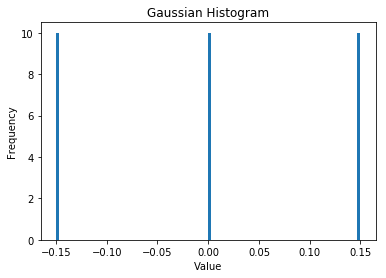

In [31]:
data, count = get_data(10)

#g = generate_batch(data, fake=True, flipit=True, rand_camera=True)

images, steers = [], []

# for el in g:
#     images.extend(el[0])
#     steers.extend(el[1])
#     if len(images) >= count:
#         break

images, steers = extract_samples_from_rows(data, [0, 1, 2], [0, -0.15, 0.15], fake=False, )#rand=True)

aug_image = create_aug_img_pipeline(accepted_angles=[0, 0.15, -0.15], fake=False)

plot_data(steers)



30
(34, 160, 3)


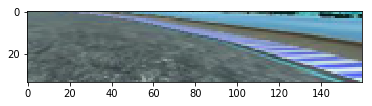

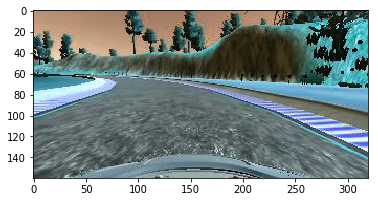

In [33]:
images_a, steers_a = zip(*list(map(aug_image, images, steers)))
print (len(steers))
#plot_data(steers_a)
plot_img(images_a[0])
plot_img(images[0])
print (images_a[0].shape)

In [ ]:
import pandas as pd
column_names = ['center', 'left', 'right',
                'steering', 'throttle', 'brake', 'speed']
data_df = pd.read_csv('data/data_ori/driving_log.csv', skiprows=[0], names=column_names)
data_df.iloc[:5]

data_df['steering'][:5]


In [ ]:
import matplotlib.pyplot as plt
#plt.figure()
#data_df['steering'].plot.figure()
data_df['steering'].plot.hist(bins=25)
plt.show()

In [ ]:
TAN_CORRECT = 25
aug_image = create_aug_img_pipeline(fake=True, accepted_angles=[0, 0.15, -0.15])
plot_data(steers)

In [ ]:
images_a, steers_a = zip(*list(map(aug_image, images, steers)))
plot_data(steers_a)

In [ ]:
# print(images_a[0].shape)
#print (sum(map(abs, rotate_net))/len(rotate_net))
print (len(steers))

In [ ]:
plot_img(images_a[20])

In [29]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Lambda, Cropping2D, Convolution2D, MaxPooling2D, Dropout, Activation
def create_new_model():
    model = Sequential()
    model.add(Lambda(lambda x: x / 127.5 - 1.,
              input_shape=(34, 160, 3),))
    model.add(Convolution2D(24, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(Activation('relu'))
    model.add(Dropout(.5))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

    model.add(Convolution2D(36, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(Activation('relu'))
    model.add(Dropout(.5))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

    model.add(Convolution2D(48, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(Activation('relu'))
    model.add(Dropout(.5))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

    model.add(Convolution2D(64, 3, 3, border_mode="same"))
    model.add(Activation('relu'))
    model.add(Dropout(.5))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

    model.add(Convolution2D(64, 3, 3, border_mode="same"))
    model.add(Activation('relu'))
    model.add(Dropout(.5))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

    model.add(Flatten())
    model.add(Dropout(.2))
    model.add(Activation('relu'))
    model.add(Dense(1164))
    model.add(Dropout(.5))
    model.add(Activation('relu'))
    model.add(Dense(100))
    model.add(Dropout(.5))
    model.add(Activation('relu'))
    model.add(Dense(50))
    model.add(Dropout(.5))
    model.add(Activation('relu'))
    model.add(Dense(10))
    model.add(Dropout(.5))
    model.add(Activation('relu'))
    model.add(Dense(1))

    model.summary()
    # model compile
    #model = Sequential(layers)

    optimizer = keras.optimizers.Adam(lr=learnrate)

    # Patch changed to mae
    model.compile(
        loss="mse",
        optimizer=optimizer,
    )
    return model
x = create_new_model()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_4 (Lambda)                (None, 34, 160, 3)    0           lambda_input_4[0][0]             
____________________________________________________________________________________________________
convolution2d_12 (Convolution2D) (None, 17, 80, 24)    1824        lambda_4[0][0]                   
____________________________________________________________________________________________________
activation_21 (Activation)       (None, 17, 80, 24)    0           convolution2d_12[0][0]           
____________________________________________________________________________________________________
dropout_21 (Dropout)             (None, 17, 80, 24)    0           activation_21[0][0]              
___________________________________________________________________________________________

NameError: name 'learnrate' is not defined

In [ ]:
import os
import csv
import cv2

import sklearn
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Lambda, Cropping2D, Convolution2D, MaxPooling2D, Dropout
import numpy as np
import matplotlib.pyplot as plt

# settings
# limit images loaded in memory by setting batch limit for generator
IMG_BATCH_SIZE = 128
# path to folder where data is kept
PATH_TO_DATA_FOLDER = 'data'
# data heirachy should be one more dir deep as this may contain multiple dirs
#   which contain different training data

LOG_FILE = 'driving_log.csv'

# for each dir entry, training data is fetched from corresponding subdirectory
# TODO add all folders
PATHS_TO_IMG_FOLDERS = ['data_center',] # 'data_ori', 'data_lap', 'data_reverse']
#'data_ori']#, 'data_sides', 'data_lap', 'data_reverse']
PATH_TO_IMG = 'IMG'

# for each dir entry, all images found will be augmented by horizontal flip
AUGMENT_DATA = ['data', 'data_2', 'data_center', 'data_ori', 'data_sides', 'data_lap', 'data_reverse']
# for each dir entry, all images will be replicated dict value times
# TODO change to 10
# Should not be a multiple of 5 for keeping sample counts estimation simple
MUTATE_DATA = {'data_center': 1, 'data_sides': 1}

# inputs
# center, left, right
STEERING_CORRECTION_FACTORS = [0, 1.0 / 10, -1.0 / 10]

# TODO set to True
INCLUDE_SIDES = False
# set to false to also augment side images
AUGMENT_CENTER_ONLY = True

# Mulitplier for counting total training samples after augmentation
camera_sides = (3 if INCLUDE_SIDES else 1)
AUGMENTED_SAMPLE_MULTIPLIER = camera_sides + (1 if AUGMENT_CENTER_ONLY else camera_sides)

samples = []
sample_count = 0
for folder in PATHS_TO_IMG_FOLDERS:
        log_file_path = os.path.join(PATH_TO_DATA_FOLDER, folder, LOG_FILE)
        count = 0
        with open(log_file_path) as logs:
            reader = csv.reader(logs)
            for row in reader:
                if row[0] == "center":
                    continue
                row.append(folder)
                samples.append(row)
                count += 1
        if folder in MUTATE_DATA:
            count *= MUTATE_DATA[folder]
        sample_count += count

# count of total samples to be processed
sample_count *= AUGMENTED_SAMPLE_MULTIPLIER


# loading data
def get_batch(samples, side_images=True):
    """Returns next (images, angle of steering) batch"""
    while True:
        samples = sklearn.utils.shuffle(samples)
        count_b = 0
        images = []
        ang = []
        for row in samples:
            folder = row[-1]

            # fetches image from given path
            def get_img(img_entry):
                path = os.path.join(PATH_TO_DATA_FOLDER, folder, PATH_TO_IMG,
                                    img_entry.split('/')[-1])
                return cv2.imread(path)

            if side_images:
                images_to_add = [get_img(row[i]) for i in range(3)]
                angs_to_add = [float(row[3]) + offset for offset in STEERING_CORRECTION_FACTORS]
            else:
                images_to_add = [get_img(row[0]), ]
                angs_to_add = [float(row[3]), ]

            # augmenting image by flipping horizontally
            if folder in AUGMENT_DATA:
                if not AUGMENT_CENTER_ONLY:
                    # augment all cameras
                    images_to_add.extend([cv2.flip(image, 1) for image in images_to_add])
                    angs_to_add.extend([angle * -1 for angle in angs_to_add])
                else:
                    # augment center camera image only
                    images_to_add.append(cv2.flip(images_to_add[0], 1))
                    angs_to_add.append(angs_to_add[0] * -1)

            # mutating data by replicating it `n` times given by dict val
            # TODO sample weights as replacement for replication?
            if folder in MUTATE_DATA:
                images_to_add = list(map(lambda x: x.copy(),
                                         images_to_add * MUTATE_DATA[folder]))
                angs_to_add = angs_to_add * MUTATE_DATA[folder]

            # adding obtained data to list
            images.extend(images_to_add)
            ang.extend(angs_to_add)

            # yielding current batch
            if len(images) >= IMG_BATCH_SIZE:
                count_b += len(images)
                # TODO shuffle each batch?
                print (len(images))
                print (np.array(images).shape)
                yield (np.array(images),
                       np.array(ang))
                images = []
                ang = []

        count_b += len(images)
        print (len(images))
        print (type(imges))
        print (np.array(images).shape)
        print (len(ang))
        print (type(ang))
        print (np.array(images).shape)
        yield (np.array(images),
               np.array(ang))


# model
# hyperparams
epochs = 10
# batch_size = 100
learnrate = 0.001

# layers
layers = [
    # preprocessing
    Lambda(lambda x: x / 255.0 - 0.5, input_shape=(160, 320, 3),),
    Cropping2D(cropping=((60, 25), (0, 0))),

    # conv 1
    Convolution2D(6, 5, 5, border_mode='valid', activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.5),

    # conv 2
    Convolution2D(16, 5, 5, border_mode='valid', activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.5),

#     # conv 3
#     Convolution2D(16, 5, 5, border_mode='valid', activation='relu'),
#     #MaxPooling2D((2, 2)),
#     Dropout(0.5),

#     # conv 4
#     Convolution2D(8, 5, 5, border_mode='valid', activation='relu'),
#     MaxPooling2D((2, 2)),
#     Dropout(0.5),

#     # conv 5
#     Convolution2D(4, 5, 5, border_mode='valid', activation='relu'),
#     MaxPooling2D((2, 2)),
#     Dropout(0.5),

    # flatten
    Flatten(),

#     # dense
#     Dense(64, activation='relu'),
#     Dropout(0.5),

#     # dense
#     Dense(64, activation='relu'),
#     Dropout(0.5),

    # dense
    Dense(32, activation='relu'),
    Dropout(0.5),

    # dense
    Dense(1,),
]

# model compile
model = Sequential(layers)

optimizer = keras.optimizers.Adam(lr=learnrate)

model.compile(
    loss="mse",
    optimizer=optimizer,
)

# shuffling samples
# TODO change to inplace shuffling with np.random.shuffle
samples = sklearn.utils.shuffle(samples)

training_samples, validation_samples = samples[:len(samples) // 5], samples[len(samples) // 5:]

validation_sample_size = sample_count // 5
training_sample_size = sample_count - validation_sample_size

train_gen = get_batch(training_samples, INCLUDE_SIDES)
validation_gen = get_batch(validation_samples, INCLUDE_SIDES)

print ("training {} samples.".format(sample_count))

history_object = model.fit_generator(train_gen, samples_per_epoch=training_sample_size,
                                     nb_epoch=epochs, validation_data=validation_gen,
                                     nb_val_samples=validation_sample_size,)

### print the keys contained in the history object
print(history_object.history.keys())

# saving history object
import pickle
with open('history.pk', 'wb') as handle:
    pickle.dump(history_object.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

### plot the training and validation loss for each epoch
# plt.plot(history_object.history['loss'])
# plt.plot(history_object.history['val_loss'])
# plt.title('model mean squared error loss')
# plt.ylabel('mean squared error loss')
# plt.xlabel('epoch')
# plt.legend(['training set', 'validation set'], loc='upper right')
# plt.show()

# model.save('model.h5')

# TODO evaluation


# behaviour cloning solution



In [ ]:
import os
import csv
import cv2

import sklearn
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Lambda, Cropping2D, Convolution2D, MaxPooling2D, Dropout
import numpy as np
import matplotlib.pyplot as plt

# settings
# limit images loaded in memory by setting batch limit for generator
IMG_BATCH_SIZE = 128
# path to folder where data is kept
PATH_TO_DATA_FOLDER = 'data'
# data heirachy should be one more dir deep as this may contain multiple dirs
#   which contain different training data

LOG_FILE = 'driving_log.csv'

In [ ]:
# for each dir entry, training data is fetched from corresponding subdirectory
# TODO add all folders
PATHS_TO_IMG_FOLDERS = ['data_sides', 'data_ori', 'data_lap', 'data_reverse']
#'data_ori']#, 'data_sides', 'data_lap', 'data_reverse']
PATH_TO_IMG = 'IMG'

# for each dir entry, all images found will be augmented by horizontal flip
AUGMENT_DATA = ['data', 'data_2', 'data_center', 'data_ori', 'data_sides', 'data_lap', 'data_reverse']
# for each dir entry, all images will be replicated dict value times
# TODO change to 10
# Should not be a multiple of 5 for keeping sample counts estimation simple
MUTATE_DATA = {'data_center': 1, 'data_sides': 1}

# inputs
# center, left, right
STEERING_CORRECTION_FACTORS = [0, 1.0 / 10, -1.0 / 10]

# TODO set to True
INCLUDE_SIDES = False
# set to false to also augment side images
AUGMENT_CENTER_ONLY = True

# Mulitplier for counting total training samples after augmentation
camera_sides = (3 if INCLUDE_SIDES else 1)
AUGMENTED_SAMPLE_MULTIPLIER = camera_sides + (1 if AUGMENT_CENTER_ONLY else camera_sides)


## Visualize Data

View a sample from the dataset.

You do not need to modify this section.

In [ ]:

samples = []
sample_count = 0
for folder in PATHS_TO_IMG_FOLDERS:
        log_file_path = os.path.join(PATH_TO_DATA_FOLDER, folder, LOG_FILE)
        count = 0
        with open(log_file_path) as logs:
            reader = csv.reader(logs)
            for row in reader:
                if row[0] == "center":
                    continue
                row.append(folder)
                samples.append(row)
                count += 1
        if folder in MUTATE_DATA:
            count *= MUTATE_DATA[folder]
        sample_count += count

# count of total samples to be processed
sample_count *= AUGMENTED_SAMPLE_MULTIPLIER


# loading data
def get_batch(samples, side_images=True):
    """Returns next (images, angle of steering) batch"""
    while True:
        samples = sklearn.utils.shuffle(samples)
        count_b = 0
        images = []
        ang = []
        for row in samples:
            folder = row[-1]

            # fetches image from given path
            def get_img(img_entry):
                path = os.path.join(PATH_TO_DATA_FOLDER, folder, PATH_TO_IMG,
                                    img_entry.split('/')[-1])
                return cv2.imread(path)

            if side_images:
                images_to_add = [get_img(row[i]) for i in range(3)]
                angs_to_add = [float(row[3]) + offset for offset in STEERING_CORRECTION_FACTORS]
            else:
                images_to_add = [get_img(row[0]), ]
                angs_to_add = [float(row[3]), ]

            # augmenting image by flipping horizontally
            if folder in AUGMENT_DATA:
                if not AUGMENT_CENTER_ONLY:
                    # augment all cameras
                    images_to_add.extend([cv2.flip(image, 1) for image in images_to_add])
                    angs_to_add.extend([angle * -1 for angle in angs_to_add])
                else:
                    # augment center camera image only
                    images_to_add.append(cv2.flip(images_to_add[0], 1))
                    angs_to_add.append(angs_to_add[0] * -1)

            # mutating data by replicating it `n` times given by dict val
            # TODO sample weights as replacement for replication?
            if folder in MUTATE_DATA:
                images_to_add = list(map(lambda x: x.copy(),
                                         images_to_add * MUTATE_DATA[folder]))
                angs_to_add = angs_to_add * MUTATE_DATA[folder]

            # adding obtained data to list
            images.extend(images_to_add)
            ang.extend(angs_to_add)

            # yielding current batch
            if len(images) >= IMG_BATCH_SIZE:
                count_b += len(images)
                # TODO shuffle each batch?
                yield (np.array(images),
                       np.array(ang))
                images = []
                ang = []

        count_b += len(images)
        yield (np.array(images),
               np.array(ang))



## Preprocess Data

Shuffle the training data.

You do not need to modify this section.

In [ ]:

# model
# hyperparams
epochs = 10
# batch_size = 100
learnrate = 0.001

# layers
layers = [
    # preprocessing
    Lambda(lambda x: x / 255.0 - 0.5, input_shape=(160, 320, 3),),
    Cropping2D(cropping=((60, 25), (0, 0))),

    # conv 1
    Convolution2D(32, 5, 5, border_mode='valid', activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.5),

    # conv 2
    Convolution2D(16, 5, 5, border_mode='valid', activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.5),

    # conv 3
    Convolution2D(16, 5, 5, border_mode='valid', activation='relu'),
    #MaxPooling2D((2, 2)),
    Dropout(0.5),

    # conv 4
    Convolution2D(8, 5, 5, border_mode='valid', activation='relu'),
    #MaxPooling2D((2, 2)),
    Dropout(0.5),

    # conv 5
    Convolution2D(4, 5, 5, border_mode='valid', activation='relu'),
    #MaxPooling2D((2, 2)),
    Dropout(0.5),

    # flatten
    Flatten(),

    # dense
    Dense(64, activation='relu'),
    Dropout(0.5),

    # dense
    Dense(64, activation='relu'),
    Dropout(0.5),

    # dense
    Dense(32, activation='relu'),
    Dropout(0.5),

    # dense
    Dense(1,),
]

# model compile
model = Sequential(layers)

optimizer = keras.optimizers.Adam(lr=learnrate)

model.compile(
    loss="mse",
    optimizer=optimizer,
)


## Setup TensorFlow
The `EPOCH` and `BATCH_SIZE` values affect the training speed and model accuracy.

You do not need to modify this section.

In [ ]:

# shuffling samples
# TODO change to inplace shuffling with np.random.shuffle
samples = sklearn.utils.shuffle(samples)

training_samples, validation_samples = samples[:len(samples) // 5], samples[len(samples) // 5:]

validation_sample_size = sample_count // 5
training_sample_size = sample_count - validation_sample_size

train_gen = get_batch(training_samples, INCLUDE_SIDES)
validation_gen = get_batch(validation_samples, INCLUDE_SIDES)

print ("training {} samples.".format(sample_count))

history_object = model.fit_generator(train_gen, samples_per_epoch=training_sample_size,
                                     nb_epoch=epochs, validation_data=validation_gen,
                                     nb_val_samples=validation_sample_size,)


## SOLUTION: Implement LeNet-5
Implement the [LeNet-5](http://yann.lecun.com/exdb/lenet/) neural network architecture.

This is the only cell you need to edit.
### Input
The LeNet architecture accepts a 32x32xC image as input, where C is the number of color channels. Since MNIST images are grayscale, C is 1 in this case.

### Architecture
**Layer 1: Convolutional.** The output shape should be 28x28x6.

**Activation.** Your choice of activation function.

**Pooling.** The output shape should be 14x14x6.

**Layer 2: Convolutional.** The output shape should be 10x10x16.

**Activation.** Your choice of activation function.

**Pooling.** The output shape should be 5x5x16.

**Flatten.** Flatten the output shape of the final pooling layer such that it's 1D instead of 3D. The easiest way to do is by using `tf.contrib.layers.flatten`, which is already imported for you.

**Layer 3: Fully Connected.** This should have 120 outputs.

**Activation.** Your choice of activation function.

**Layer 4: Fully Connected.** This should have 84 outputs.

**Activation.** Your choice of activation function.

**Layer 5: Fully Connected (Logits).** This should have 10 outputs.

### Output
Return the result of the 2nd fully connected layer.

In [ ]:
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

## Features and Labels
Train LeNet to classify [MNIST](http://yann.lecun.com/exdb/mnist/) data.

`x` is a placeholder for a batch of input images.
`y` is a placeholder for a batch of output labels.

You do not need to modify this section.

In [ ]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

## Training Pipeline
Create a training pipeline that uses the model to classify MNIST data.

You do not need to modify this section.

In [ ]:
rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

## Model Evaluation
Evaluate how well the loss and accuracy of the model for a given dataset.

You do not need to modify this section.

In [ ]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

## Train the Model
Run the training data through the training pipeline to train the model.

Before each epoch, shuffle the training set.

After each epoch, measure the loss and accuracy of the validation set.

Save the model after training.

You do not need to modify this section.

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

## Evaluate the Model
Once you are completely satisfied with your model, evaluate the performance of the model on the test set.

Be sure to only do this once!

If you were to measure the performance of your trained model on the test set, then improve your model, and then measure the performance of your model on the test set again, that would invalidate your test results. You wouldn't get a true measure of how well your model would perform against real data.

You do not need to modify this section.

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))